In [1]:
%load_ext autoreload
%autoreload 2

# Load EMA weights

In [2]:
from pathlib import Path
from omegaconf import OmegaConf

import torch
from plaid.diffusion import FunctionOrganismDiffusion
from plaid.denoisers import FunctionOrganismUDiT, DenoiserKwargs
from plaid.constants import COMPRESSION_INPUT_DIMENSIONS, COMPRESSION_SHORTEN_FACTORS

device = torch.device("cuda")

/homefs/home/lux70/micromamba/envs/flash_attn/lib/python3.11/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/homefs/home/lux70/micromamba/envs/flash_attn/lib/python3.11/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
/homefs/home/lux70/code/plaid/src/plaid/diffusion/cfg.py:470: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


In [3]:
model_id = "5j007z42"

ckpt_dir = Path("/data/lux70/plaid/checkpoints/plaid-compositional") 
model_path = ckpt_dir / model_id / "last.ckpt"
config_path = ckpt_dir / model_id / "config.yaml"

cfg = OmegaConf.load(config_path)

In [4]:
compression_model_id = cfg['compression_model_id']
shorten_factor = COMPRESSION_SHORTEN_FACTORS[compression_model_id]
input_dim = COMPRESSION_INPUT_DIMENSIONS[compression_model_id]

In [5]:
denoiser_kwargs = cfg.denoiser
denoiser_kwargs.pop("_target_")
denoiser = FunctionOrganismUDiT(**denoiser_kwargs, input_dim=input_dim)

In [6]:
# lask.ckpt automatically links to the EMA

ckpt = torch.load(model_path)
ckpt.keys()

/tmp/ipykernel_603334/2446128762.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path)


dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])

In [7]:
mod_state_dict = {}
for k, v in ckpt['state_dict'].items():
    if k[:16] == "model._orig_mod.":
        mod_state_dict[k[16:]] = v

In [8]:
denoiser.load_state_dict(mod_state_dict)

<All keys matched successfully>

In [9]:
diffusion_kwargs = cfg.diffusion
diffusion_kwargs.pop("_target_")

# diffusion_kwargs['beta_scheduler_name'] = "sigmoid"
# diffusion_kwargs['sampling_timesteps'] = 500

diffusion = FunctionOrganismDiffusion(model=denoiser,**diffusion_kwargs)

In [10]:
from cheap.pretrained import load_model_from_id
cheap_model = load_model_from_id(compression_model_id)
_ = cheap_model.to(device)

from cheap.proteins import LatentToSequence,LatentToStructure
latent_to_sequence = LatentToSequence()
latent_to_sequence.to(device)

latent_to_structure = LatentToStructure()
latent_to_structure.to(device)

/homefs/home/lux70/code/cheap-proteins/src/cheap/pretrained.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_fpath)


Using tanh layer at bottleneck...
Finished loading HPCT model with shorten factor 2 and 32 channel dimensions.


/homefs/home/lux70/code/cheap-proteins/src/cheap/decoder.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path)
Creating ESMFold...
ESMFold model 

# Sample

In [11]:
# organism_idx = org_df[org_df.organism_id == "HUMAN"].organism_index.iloc[0]
# function_idx = go_df[go_df.GO_term == "carbohydrate metabolic process"].GO_idx.iloc[0]
# print(organism_idx, function_idx)

In [12]:
device = torch.device("cuda")
diffusion = diffusion.to(device)

In [46]:
from plaid.datasets import NUM_ORGANISM_CLASSES, NUM_FUNCTION_CLASSES

N, L = 64, 128
assert L % 4 == 0

shape = (N, L, input_dim)

organism_idx = NUM_ORGANISM_CLASSES
function_idx = NUM_FUNCTION_CLASSES

cond_scale = 100

diffusion.sampling_timesteps=1000

sampled_latent = diffusion.ddim_sample_loop(
    shape=shape,
    organism_idx=organism_idx,
    function_idx=function_idx,
    return_all_timesteps=True,
    cond_scale=cond_scale,
)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
print(sampled_latent.shape)
final_sample = sampled_latent[:, -1, :, :]
print(final_sample.shape)

print(final_sample.max(), final_sample.min())

torch.Size([64, 1001, 128, 32])
torch.Size([64, 128, 32])
tensor(1.0213, device='cuda:0') tensor(-1.0134, device='cuda:0')


In [48]:
sampled_uncompressed = cheap_model.decode(final_sample, downsampled_mask=None)
print(sampled_uncompressed.min(), sampled_uncompressed.max())

tensor(-1.2086, device='cuda:0') tensor(1.0904, device='cuda:0')


In [49]:
# import pickle as pkl
# with open("test_sample.pkl", "wb") as f:
#     pkl.dump(sampled_uncompressed,f)

In [50]:
from cheap.utils import LatentScaler
latent_scaler = LatentScaler()
sampled_unscaled = latent_scaler.unscale(sampled_uncompressed) 

In [51]:
print(sampled_unscaled.shape)
print(sampled_unscaled.max(), sampled_unscaled.min())

torch.Size([64, 256, 1024])
tensor(2905.9548, device='cuda:0') tensor(-896.4462, device='cuda:0')


In [52]:
sequences = latent_to_sequence.to_sequence(sampled_unscaled)[-1]

In [53]:
sequences[:3]

['AEVAADEDHRSQITLPEQALQQLLEDLDHMAARVARSRRQRDSLENAASITRIQAEKLNGWSEEVAKKTRAFEERFEATGANPTEIQVRDALIAQQAKQETSLRQLRQADSESDWYLGQLARKDNLIADSQDRVRNITSILQTLSEPKSSELGAGENFLRIRPSSEGLDRIARQEIAFAELELRQQKTQQDDLVAEQESRRAAAIQFNLELRRLEDIVRERRQLLAVKAVAENDRIAAERPAEIAHLVQPSRYRLK',
 'AHVIFLLPPRFGDGLKWMQNSYFTQLPIPVLILIFFGRLGWAYLDKHPISAWIFLAGLALFILNVFSGFYLSELGAAIAIGLIILAFLRQPLVKLVWGYNQMFPLVNVFQVLPTDGSPWGQTLIQEYGPTLTSEVTRTACFLMDVPVYLEGSLILVGDRKLEVDVACTDISTKLFMLFAFIVLLNAFWNRKQSFSETVSLFSFLAIAVLVANFLRIASLTLKGYYGKEFVDGDSHQITGVILSAMLLLFTLLAQRW',
 'IPKKGHPSDCTNFRPIALQNVDYKIIARIIAARIASSINTIISYEQSVYKRGRCVCDKLFLLKKELQYWRADEGKSGFLLLFIDMEKAFDRLGWEFLKLILRTVGFGQSLVEWMYTLITCQSVAVDYQDEIQFRFTEGLRQGDPLSPILFSILCEVLYQRIECSLPNLTGIKVGEAKLKASLFADDLILFLEGTQESVYSVLDALSLFSAYSGLKINESKSSIVIVGRRQEMLLELKRVYPYKAISGPVTYLGIPM']

In [54]:
pdb_strs, raw_outputs = latent_to_structure.to_structure(sampled_unscaled, return_raw_outputs=True, sequences=sequences, batch_size=32, num_recycles=1)

(Generating structure): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.16s/it]


/tmp/ipykernel_603334/2582915834.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(raw_outputs['plddt'].mean(dim=-1).mean(dim=-1).cpu().numpy(), bins=30)


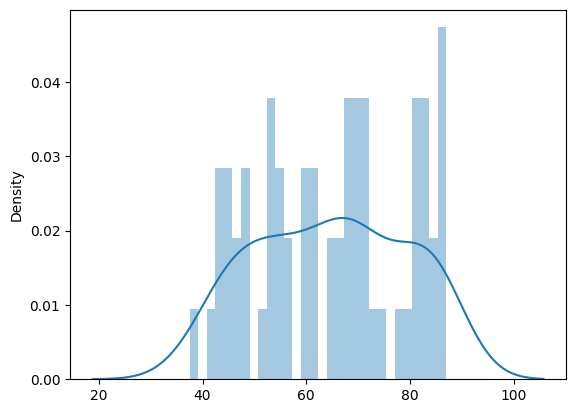

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

_ = sns.distplot(raw_outputs['plddt'].mean(dim=-1).mean(dim=-1).cpu().numpy(), bins=30)

In [56]:
import py3Dmol

# for i in range(len(pdb_strs)):
# for i in range(10,20): 
# for i in range(0, 10): 
for i in range(20,30): 
    view = py3Dmol.view(width=600, height=600)
    view.addModelsAsFrames(pdb_strs[i])
    
    # Apply the plDDT color scheme
    # view.setStyle({'cartoon': {'color': {'prop': 'b', 'gradient': 'roygb', 'min': 0, 'max': 100}}})
    view.setStyle({'cartoon': {'color': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
    
    # # Add surface representation with plDDT-based color
    view.addSurface(py3Dmol.VDW, {'opacity': 0.7, 'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}})
    # view.addSurface(py3Dmol.VDW, {'opacity': 0.7, 'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 0, 'max': 100}})

    view.zoomTo()
    view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [57]:
from plaid.evaluation import RITAPerplexity

perplexity_calc = RITAPerplexity(device=device)
perplexities = perplexity_calc.batch_eval(sequences)

/homefs/home/lux70/micromamba/envs/flash_attn/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [58]:
perplexities = [perplexity_calc.calc_perplexity(s) for s in sequences]

/tmp/ipykernel_603334/1157264804.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(perplexities, bins=30)


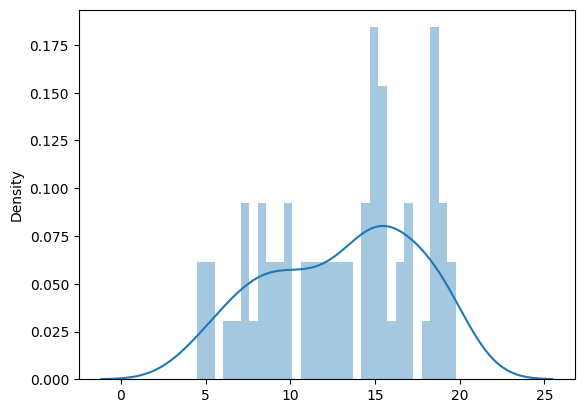

In [59]:
import seaborn as sns
_ = sns.distplot(perplexities, bins=30)

In [60]:
import numpy as np
np.mean(perplexities)

13.050936332670142

In [61]:
from plaid.utils import write_to_fasta


write_to_fasta(
    sequences,
    "/homefs/home/lux70/generated.fasta",
    [f"sample{i}" for i in range(len(sequences))]
)

Wrote 64 sequences to /homefs/home/lux70/generated.fasta.
